# Data reduction and calibration

In this notebook, we will reduce data from NIRCam observations of WASP-39 (ERS program -- pid:1366). We will start with uncalibrated data (`*uncal.fits`) and first perform detector level corrections using the `jwst` pipeline. We will then extract the spectral transit lightcurves from the data.

Note that much of the material (even the code) presented here is depends on `JWebbinar` given on TSO (specifically based on [this notebook](https://github.com/spacetelescope/jwebbinar_prep/blob/main/tso_session/ExploringTSOProducts.ipynb)). This analysis also helped from [Espinoza et al. (2022)](https://arxiv.org/abs/2211.01459).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from numpy.polynomial import chebyshev
from scipy.ndimage import median_filter
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d, splrep,splev
from jwst import datamodels
from astropy.io import fits
from astropy.timeseries import LombScargle
from jwst.pipeline import calwebb_detector1
from jwst.pipeline import calwebb_spec2
from transitspectroscopy import jwst as tjst
from transitspectroscopy import spectroscopy as tspec

In [2]:
# Path of the data and output location
p1 = os.getcwd()

pin = '/'.join(p1.split('/')[:-1]) + '/Data/S0_NIRCam'
pout = p1 + '/Outputs/Analysis1_Seg1'

# Creating the output directory
if not os.path.exists(pout):
    os.mkdir(pout)

fname = 'jw01366002001_04103_00001-seg001_nrcalong_uncal.fits'

In [3]:
# Loading the data
uncal = datamodels.RampModel(pin + '/' + fname)
uncal

<RampModel(119, 12, 256, 2048) from jw01366002001_04103_00001-seg001_nrcalong_uncal.fits>

That's nice! So, we have just loaded the first segment of our 4D data. The dimension of the data is (nintegrations, ngroups, nrows, ncolumns). That means, our data has total 119 integrations and each integration is made up of 12 groups. On the other hand the size of image (subarray) in 256 $\times$ 2048 pixels.

## `Detector1` Stage

### Step 1: `dq` init

`dq` stands for data quality. This flag will initialize data quality flags for the given datamodel. It will give `0` flag to all good data and `2147483648` to reference pixels (pixels insensitive to light), while different other flags to different types of data pixels (e.g., hot pixels, bad pixels). This step will create sort of `dq` instance which will store all these flags both image-wise and group-wise. Flagged pixels will masked during ramp-fitting step.

In [4]:
# Run step:
dq_results = calwebb_detector1.dq_init_step.DQInitStep.call(uncal, 
                                                            output_dir=pout, 
                                                            save_results=True)

2022-11-18 22:50:22,167 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2022-11-18 22:50:22,324 - stpipe.DQInitStep - INFO - Step DQInitStep running with args (<RampModel(119, 12, 256, 2048) from jw01366002001_04103_00001-seg001_nrcalong_uncal.fits>,).
2022-11-18 22:50:22,325 - stpipe.DQInitStep - INFO - Step DQInitStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/japa6985/Documents/JWST/jwst-ers/WASP-39_NC1/Outputs/Analysis1_Seg1', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2022-11-18 22:50:22,345 - stpipe.DQInitStep - INFO - Using MASK reference file /Users/japa6985/crds_cache/references/jwst/nircam/jwst_nircam_mask_0063.fits
2022-11-18 22:50:28,507 - stpipe.DQInitStep - INFO - Extracting mask subarray to match science data
2022-11-18 22:50:28,527 - stpipe.DQInitStep - INFO - Results used CRDS co

Let's vizualize these bad/hot/flagged pixels...

Total fraction of special pixels is: 0.0030002593994140625


Text(0.5, 1.0, 'Special pixels in our frame:')

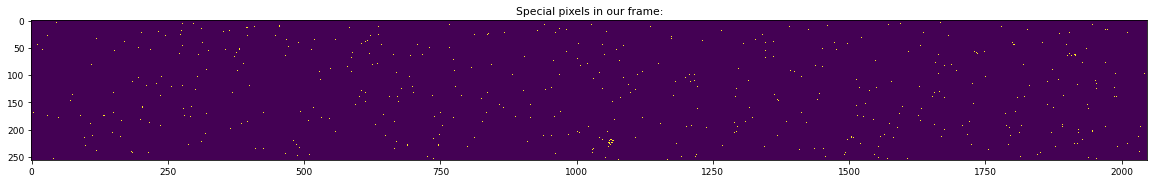

In [7]:
# To get the bad pixels, we need to use the "pixeldq" which sets the general data quality for each pixel:
dq_pixels = dq_results.pixeldq

# Identify pixels which are NOT OK and are NOT reference pixels --- we call those "special" pixels:
idx_special_pixels = np.where((dq_pixels != 0)&(dq_pixels != 2147483648))

special_pixels = np.zeros(dq_results.data[0, 0, :, :].shape)
# Identify "special" pixels as ones in this array (initially) zero-array:
special_pixels[idx_special_pixels] = 1.

tot_nos_special_pix = np.sum(special_pixels)
print('Total fraction of special pixels is:', tot_nos_special_pix/(256*2048))

# Plot them:
plt.figure(figsize=(20,7))
im = plt.imshow(special_pixels, interpolation = 'None')
im.set_clim(0,1)
plt.title('Special pixels in our frame:')

There are couple of them --- 0.3 % of the total pixels, to be more precise. That's not much of it. And their distribution on the detector looks random. So, nothing to worry about this here!

### Step 2: Saturation

This step of `jwst` pipeline looks for saturated pixels in the image. This is done at group level, i.e., the pipeline looks for saturation level for a given pixels at each group. This would make sure that while some pixels are not saturated in the first group, but can be saturated in final groups. The whole process depends on the saturation calibration reference file. The pipeline will ``compare'' the data with this reference file and mark those pixel groups which have counts well above the reference level.

In [8]:
saturation_results = calwebb_detector1.saturation_step.SaturationStep.call(dq_results , 
                                                                           output_dir=pout, 
                                                                           save_results=True)

2022-11-18 23:49:06,315 - stpipe.SaturationStep - INFO - SaturationStep instance created.
2022-11-18 23:49:06,552 - stpipe.SaturationStep - INFO - Step SaturationStep running with args (<RampModel(119, 12, 256, 2048) from jw01366002001_04103_00001-seg001_nrcalong_dqinitstep.fits>,).
2022-11-18 23:49:06,556 - stpipe.SaturationStep - INFO - Step SaturationStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/japa6985/Documents/JWST/jwst-ers/WASP-39_NC1/Outputs/Analysis1_Seg1', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}
2022-11-18 23:49:06,615 - stpipe.SaturationStep - INFO - Using SATURATION reference file /Users/japa6985/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0091.fits
2022-11-18 23:49:15,494 - stpipe.SaturationStep - INFO - Extracting reference file subarray to match scienc

Let's visualize saturations in the first and last group (for 0th integration)!

Text(0.5, 1.0, 'Saturated pixels on LAST group, first integration:')

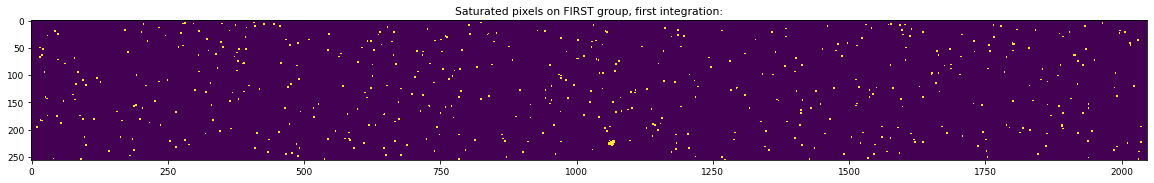

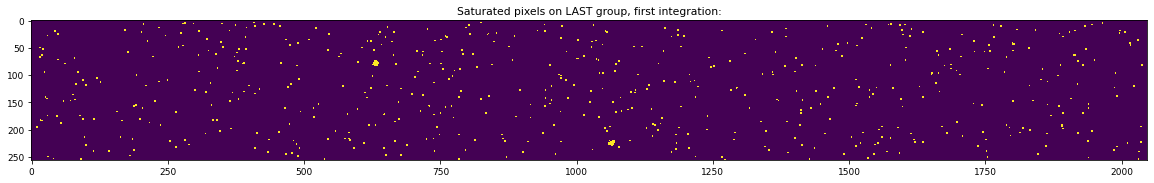

In [9]:
# Extract group data-quality:
dq_groups = saturation_results.groupdq        # This is the same quality array which was
                                              # initialized in step 1

# Identify saturated pixels in the first and last groups: (flag = 2 corresponds to saturation)
idx_sat_pixels_first_group = np.where(dq_groups[0, 0, :, :] == 2)
idx_sat_pixels_last_group = np.where(dq_groups[0, -1, :, :] == 2)

# Extract a zero-array with the same shape as the original frames; use first group, first integration as reference:
saturated_pixels_firstgroup = np.zeros(saturation_results.data[0, 0, :, :].shape)
saturated_pixels_lastgroup = np.zeros(saturation_results.data[0, 0, :, :].shape)

# Identify "saturated" pixels as ones in this array (initially) zero-array:
saturated_pixels_firstgroup[idx_sat_pixels_first_group] = 1.

# Plot them:
plt.figure(figsize=(20,5))
im = plt.imshow(saturated_pixels_firstgroup, interpolation = 'None')
im.set_clim(0,1)
plt.title('Saturated pixels on FIRST group, first integration:')

# Repeat for last group:
saturated_pixels_lastgroup[idx_sat_pixels_last_group] = 1.

# Plot them:
plt.figure(figsize=(20,5))
im = plt.imshow(saturated_pixels_lastgroup, interpolation = 'None')
im.set_clim(0,1)
plt.title('Saturated pixels on LAST group, first integration:')

There seems to be at least some difference between saturation pattern of the first and the last group, e.g., that blob of pixel at row $\sim 70$ and column $\sim 650$. These pixels will not be included in the final ramp-fitting stage.

One can actually see how the saturation reference file looks like, but I am not going to go into that details. Instead we will proceed to the next stage.

### Step 3: Reference pixel correction (and superbias step)

Although it is not to see in the images above, the 4 rows of pixel on the lower edge (i.e., row no. 0 to 4 -- seen upside in the plots above) are peculier in that they are not sensitive to light. Hence all the variations in these pixels are due to detector (readout) noise. We can use these pixels to correct for detector noise.

However, before proceeding to `refpix` step, let's first perform the `superbias` step which will, as its name suggests, correct for bias in the image.

In [10]:
superbias_results = calwebb_detector1.superbias_step.SuperBiasStep.call(saturation_results , 
                                                                        output_dir=pout,
                                                                        save_results=True)

2022-11-19 00:04:05,644 - stpipe.SuperBiasStep - INFO - SuperBiasStep instance created.
2022-11-19 00:04:05,864 - stpipe.SuperBiasStep - INFO - Step SuperBiasStep running with args (<RampModel(119, 12, 256, 2048) from jw01366002001_04103_00001-seg001_nrcalong_saturationstep.fits>,).
2022-11-19 00:04:05,866 - stpipe.SuperBiasStep - INFO - Step SuperBiasStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/japa6985/Documents/JWST/jwst-ers/WASP-39_NC1/Outputs/Analysis1_Seg1', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2022-11-19 00:04:05,903 - stpipe.SuperBiasStep - INFO - Using SUPERBIAS reference file /Users/japa6985/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0048.fits
2022-11-19 00:04:16,587 - stpipe.SuperBiasStep - INFO - Results used CRDS context: jwst_1017.pmap
2022-11-19 00:04:34,578 - stpipe.Su

Let's check the data before and after the superbias step:

Text(0.5, 1.0, 'Difference:')

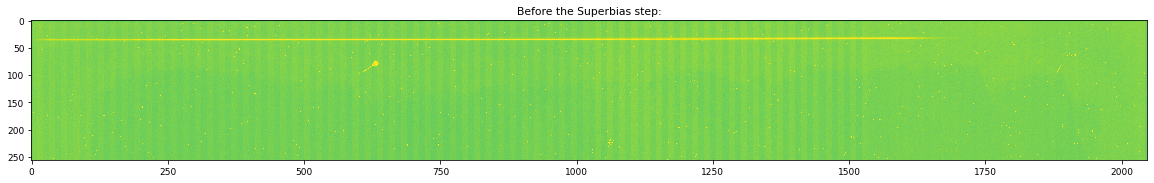

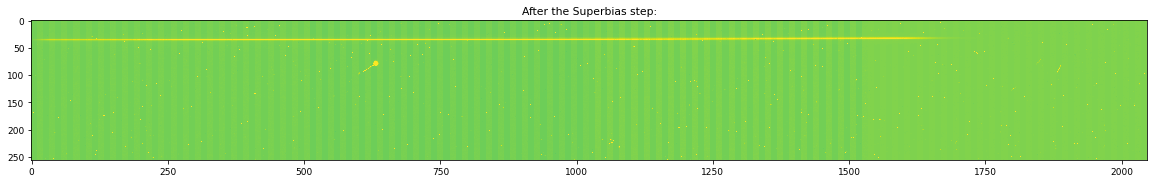

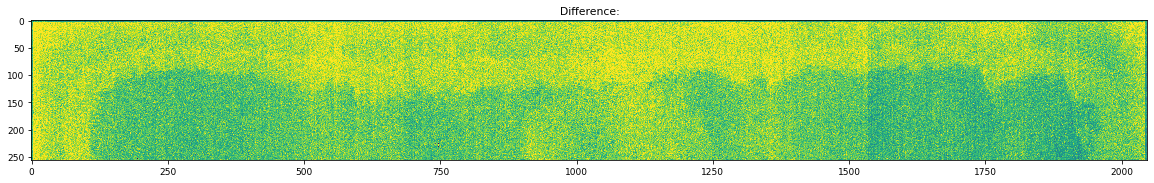

In [24]:
# Plot them:
plt.figure(figsize=(20,5))
im = plt.imshow(saturation_results.data[0,-1,:,:] / np.nanmedian(saturation_results.data[0,-1,:,:]), \
                interpolation = 'None')
im.set_clim(-3,2)
plt.title('Before the Superbias step:')

# Plot them:
plt.figure(figsize=(20,5))
im = plt.imshow(superbias_results.data[0,-1,:,:] / np.nanmedian(superbias_results.data[0,-1,:,:]), \
                interpolation = 'None')
im.set_clim(-3,2)
plt.title('After the Superbias step:')

diff_sat_bias = superbias_results.data[0,-1,:,:] - saturation_results.data[0,-1,:,:]
plt.figure(figsize=(20,5))
im = plt.imshow(diff_sat_bias / np.nanmedian(diff_sat_bias), \
                interpolation = 'None')
im.set_clim(-3,2)
plt.title('Difference:')

So, although the difference in the data before and after the superbias step is not visible in the data file, it is there! And correct for much of the systematics.

But, man, look at those vertical stripes in the data -- are they real? Let's zoom-in at the data!

Text(0.5, 1.0, 'After the Superbias step:')

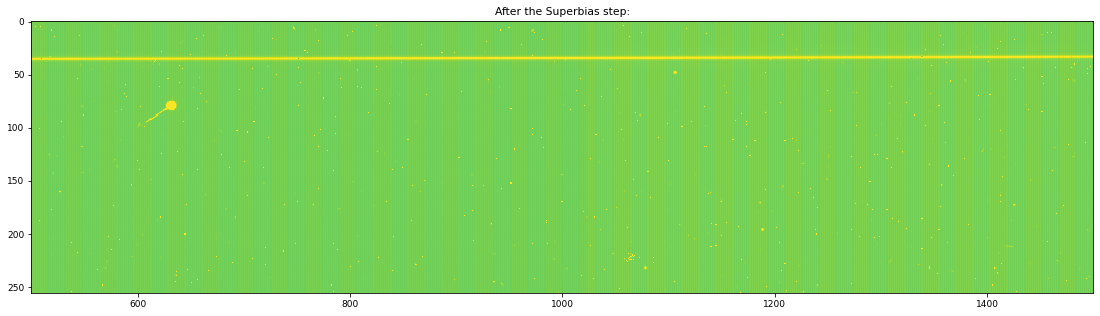

In [17]:
# Plot them:
plt.figure(figsize=(20,5))
im = plt.imshow(superbias_results.data[0,-1,:,:] / np.nanmedian(superbias_results.data[0,-1,:,:]), \
                interpolation = 'None')
im.set_clim(-3,2)
plt.xlim([500, 1500])
plt.title('After the Superbias step:')

Okay, so those vertical stripes is just optical illusion -- but there are certainly some vertical feature presents in the data: 1/f noise!

Let's visualise this at the pixel level. We will make a cut at certain column number (say, 1000) and see how the counts vary over raws, before and after superbias step. We will do this for 0th integration and the last group.

Text(0, 0.5, 'Counts - Median Counts')

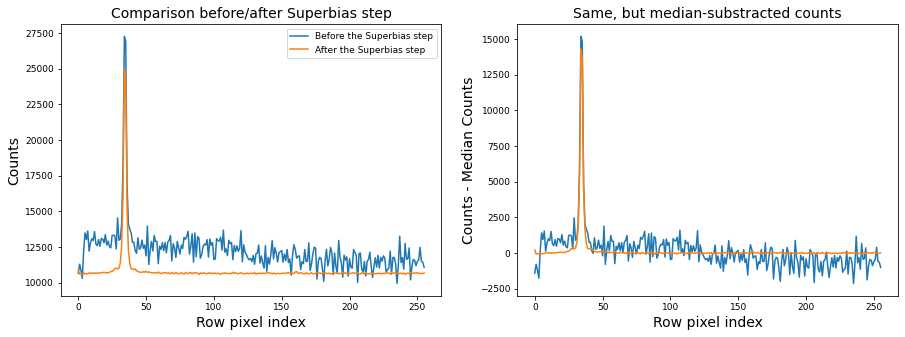

In [26]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))

ax[0].plot(saturation_results.data[0,-1,:,1010], label = 'Before the Superbias step')
ax[0].plot(superbias_results.data[0,-1,:,1010], label = 'After the Superbias step')
ax[0].set_xlabel('Row pixel index', fontsize = 14)
ax[0].set_ylabel('Counts', fontsize = 14)
ax[0].set_title('Comparison before/after Superbias step', fontsize = 14)
ax[0].legend()

ax[1].set_title('Same, but median-substracted counts', fontsize = 14)
ax[1].plot(saturation_results.data[0,-1,:,1010] - np.nanmedian(saturation_results.data[0,-1,:,1010]))
ax[1].plot(superbias_results.data[0,-1,:,1010] - np.nanmedian(superbias_results.data[0,-1,:,1010]))
ax[1].set_xlabel('Row pixel index', fontsize = 14)
ax[1].set_ylabel('Counts - Median Counts', fontsize = 14)

So, the superbias step does correct for some short term variations! Although there is some very minute variations are still there in the data after the superbias step, it is very minimal. And the `refpix` step should be able to handle this very well!

In [27]:
refpix_results = calwebb_detector1.refpix_step.RefPixStep.call(superbias_results, 
                                                                     output_dir=pout, 
                                                                     save_results=True)

2022-11-19 00:21:59,433 - stpipe.RefPixStep - INFO - RefPixStep instance created.
2022-11-19 00:21:59,585 - stpipe.RefPixStep - INFO - Step RefPixStep running with args (<RampModel(119, 12, 256, 2048) from jw01366002001_04103_00001-seg001_nrcalong_superbiasstep.fits>,).
2022-11-19 00:21:59,587 - stpipe.RefPixStep - INFO - Step RefPixStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/japa6985/Documents/JWST/jwst-ers/WASP-39_NC1/Outputs/Analysis1_Seg1', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}
2022-11-19 00:22:08,088 - stpipe.RefPixStep - INFO - NIR subarray data
2022-11-19 00:22:08,099 - stpipe.RefPixStep - INFO - 4 readout amplifiers used
2022-11-19 00:22:08,100 - stpipe.RefPixStep - 

Text(0.5, 1.0, 'After the RefPix step:')

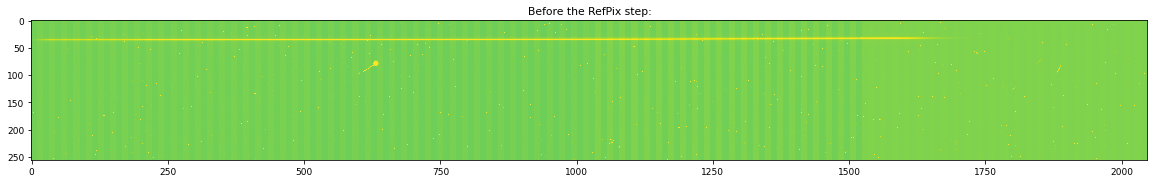

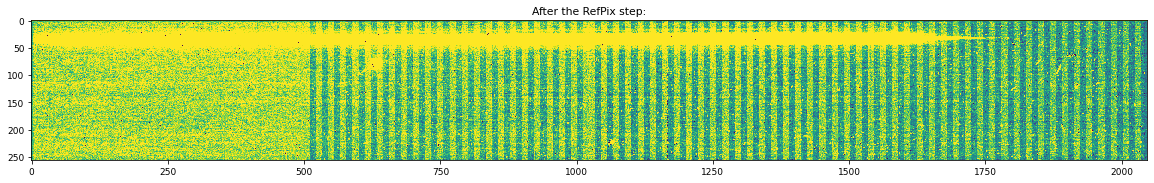

In [28]:
# Plot them:
plt.figure(figsize=(20,5))
im = plt.imshow(superbias_results.data[0,-1,:,:] / np.nanmedian(superbias_results.data[0,-1,:,:]), \
                interpolation = 'None')
im.set_clim(-3,2)
plt.title('Before the RefPix step:')

# Plot them:
plt.figure(figsize=(20,5))
im = plt.imshow(refpix_results.data[0,-1,:,:] / np.nanmedian(refpix_results.data[0,-1,:,:]), \
                interpolation = 'None')
im.set_clim(-3,2)
plt.title('After the RefPix step:')

WHAT??? I am sure, that is just optical illusion. Let's zoom in!

Text(0.5, 1.0, 'After the RefPix step:')

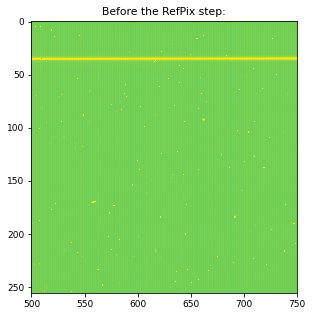

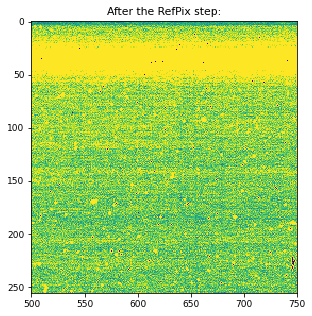

In [30]:
# Plot them:
plt.figure(figsize=(20,5))
im = plt.imshow(superbias_results.data[10,-1,:,:] / np.nanmedian(superbias_results.data[10,-1,:,:]), \
                interpolation = 'None')
im.set_clim(-3,2)
plt.xlim([500, 750])
plt.title('Before the RefPix step:')

# Plot them:
plt.figure(figsize=(20,5))
im = plt.imshow(refpix_results.data[10,-1,:,:] / np.nanmedian(refpix_results.data[10,-1,:,:]), \
                interpolation = 'None')
im.set_clim(-3,2)
plt.xlim([500, 750])
plt.title('After the RefPix step:')

I am not so sure -- let's look at a cut at 1010th column.

Text(0, 0.5, 'Counts - Median Counts')

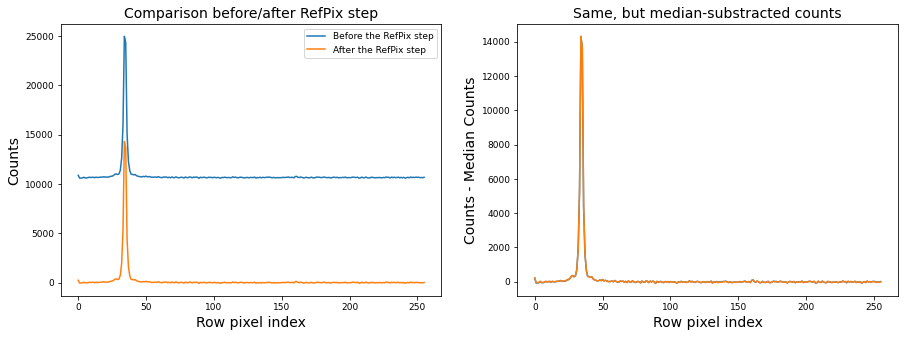

In [31]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))

ax[0].plot(superbias_results.data[0,-1,:,1010], label = 'Before the RefPix step')
ax[0].plot(refpix_results.data[0,-1,:,1010], label = 'After the RefPix step')
ax[0].set_xlabel('Row pixel index', fontsize = 14)
ax[0].set_ylabel('Counts', fontsize = 14)
ax[0].set_title('Comparison before/after RefPix step', fontsize = 14)
ax[0].legend()

ax[1].set_title('Same, but median-substracted counts', fontsize = 14)
ax[1].plot(superbias_results.data[0,-1,:,1010] - np.nanmedian(superbias_results.data[0,-1,:,1010]))
ax[1].plot(refpix_results.data[0,-1,:,1010] - np.nanmedian(refpix_results.data[0,-1,:,1010]))
ax[1].set_xlabel('Row pixel index', fontsize = 14)
ax[1].set_ylabel('Counts - Median Counts', fontsize = 14)

Okay, I see why in the above pictures the data after `refpix` looks more noisy -- it is because the scale is different in both images. It is clearly visible in the column cut that the `refpix` step at least did not include noise. But did it improve? Let's zoom in in the cut in the bckground region (because due to high number of counts in source position, we cannot see the small variations in the data)!

Text(0, 0.5, 'Counts - Median Counts')

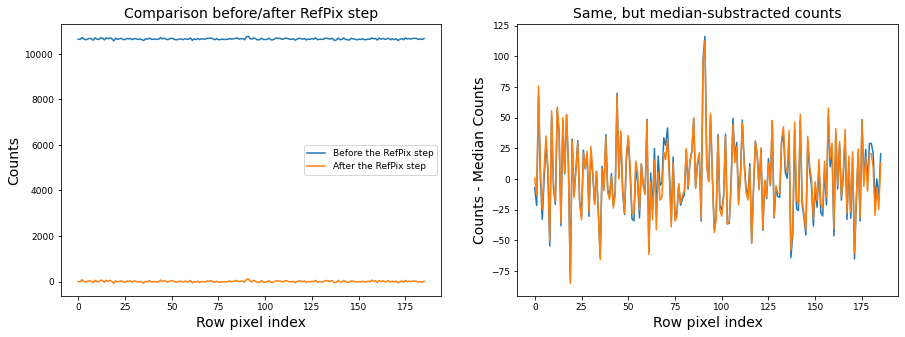

In [33]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))

ax[0].plot(superbias_results.data[0,-1,70:,1010], label = 'Before the RefPix step')
ax[0].plot(refpix_results.data[0,-1,70:,1010], label = 'After the RefPix step')
ax[0].set_xlabel('Row pixel index', fontsize = 14)
ax[0].set_ylabel('Counts', fontsize = 14)
ax[0].set_title('Comparison before/after RefPix step', fontsize = 14)
ax[0].legend()

ax[1].set_title('Same, but median-substracted counts', fontsize = 14)
ax[1].plot(superbias_results.data[0,-1,70:,1010] - np.nanmedian(superbias_results.data[0,-1,70:,1010]))
ax[1].plot(refpix_results.data[0,-1,70:,1010] - np.nanmedian(refpix_results.data[0,-1,70:,1010]))
ax[1].set_xlabel('Row pixel index', fontsize = 14)
ax[1].set_ylabel('Counts - Median Counts', fontsize = 14)

Okay, so to be completely honest --- the `refpix` step doesn't improve that much. But, well it didn't degrade the quality. So, let's keep it!

But is that high frequency noise that I am seeing?! The so-called odd-even noise? Let's first vizualise if this is indeed true or not.

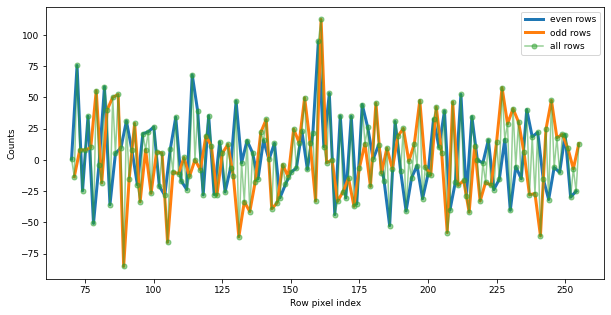

In [40]:
plt.figure(figsize=(10,5))
even = np.arange(70,256,2)
odd = np.arange(71,256,2)
all1 = np.arange(70,256,1)

plt.plot(even, refpix_results.data[0,-1,even,1010], lw=3, label='even rows')
plt.plot(odd, refpix_results.data[0,-1,odd,1010],lw=3, label='odd rows')
plt.plot(all1,refpix_results.data[0,-1,70:,1010],'-o',alpha=0.5, label='all rows')
plt.xlabel('Row pixel index')
plt.ylabel('Counts')
plt.legend()
#plt.xlim(0,256)

So, it doesn't really looks like odd-even structure. But, to make things 100 per cent sure, let's directly vizualise reference pixels (first 4 columns, or last 4 columns).

(11050.0, 11200.0)

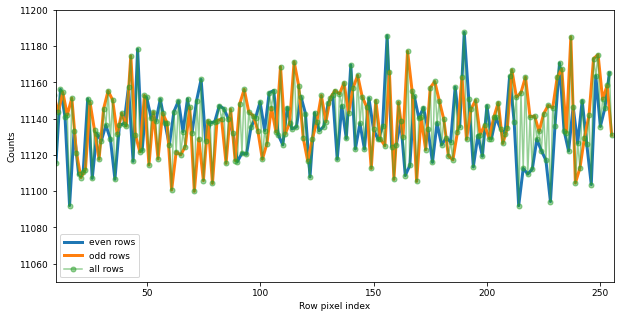

In [45]:
plt.figure(figsize=(10,5))
even = np.arange(0,256,2)
odd = np.arange(1,256,2)

plt.plot(even, superbias_results.data[0,-1,even,0], lw=3, label='even rows')
plt.plot(odd, superbias_results.data[0,-1,odd,0],lw=3, label='odd rows')
plt.plot(superbias_results.data[0,-1,:,0],'-o',alpha=0.5, label='all rows')
plt.xlabel('Row pixel index')
plt.ylabel('Counts')
plt.legend()
plt.xlim(10,256)
plt.ylim(11050,11200)

Noooo... this is definately not odd-even effect! So, forget about this! The data that we have, after `refpix` step is the best we can have. So, let's move to the linearity correction step.

### Step 4: Linearity correction

